# Model Building

This notebook trains and examins different ML classifiers on training data dataset. 

* K Nearest neighbours
* SVM
* Random forest
* Logistic regression
* Decision Tree
* ADABoost
* ANN

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import pickle

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df_tr = pd.read_csv('./data/train_features_processed.csv')
y_tr = pd.read_csv('./data/train_labels_processed.csv')
y_tr = y_tr.squeeze()

In [3]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      891 non-null    float64
 1   SibSp    891 non-null    float64
 2   Parch    891 non-null    float64
 3   Fare     891 non-null    float64
 4   female   891 non-null    float64
 5   C        891 non-null    float64
 6   Q        891 non-null    float64
 7   Class_2  891 non-null    float64
 8   Class_3  891 non-null    float64
dtypes: float64(9)
memory usage: 62.8 KB


## 1. Splitting training data
 Split training dataset into training dataset, cross validation dataset and test dataset - 55%,25% and 20% resp. 

In [4]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(df_tr,
                                                              y_tr,
                                                              test_size=0.2,
                                                              random_state=42)

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train_temp,
                                                y_train_temp,
                                                test_size=0.25)

In [6]:
type(y_train)

pandas.core.series.Series

## 2. Model development

In [7]:
def bestModel(model, X_train, X_cv, y_train, y_cv, grid):
    model_cv = GridSearchCV(model, grid, cv=4)
    model_cv.fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", model_cv.best_params_)
    print("accuracy :", model_cv.best_score_)
    mod_best= model_cv.best_estimator_
    return mod_best


def testModel(model, X_train, X_cv, y_train, y_cv):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred_cv = model.predict(X_cv)
    precision_tr, recall_tr, fscore_tr, support_tr = precision_recall_fscore_support(
        y_train, y_pred_tr, average='macro')
    precision_cv, recall_cv, fscore_cv, support_cv = precision_recall_fscore_support(
        y_cv, y_pred_cv, average='macro')
    report= np.array([precision_tr, recall_tr, fscore_tr, precision_cv, recall_cv, fscore_cv])
    return report

### 1. Logistic Regression

In [8]:
logReg = LogisticRegression(class_weight='auto', max_iter=200)
grid = {
    'C': np.logspace(-5, 0, 40),
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}
logReg_best=bestModel(logReg, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'C': 0.09426684551178845, 'solver': 'newton-cg'}
accuracy : 0.80524071372461


### 2. K-Nearest neighbours

In [9]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': np.int0(np.linspace(3, 22, 20)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_best=bestModel(knn, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
accuracy : 0.8183705532487937


### 3. Decision tree

In [10]:
decTree = DecisionTreeClassifier()
grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}
decTree_best=bestModel(decTree, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'splitter': 'random'}
accuracy : 0.7584586466165414


### 4. Random forest

In [11]:
rnFr = RandomForestClassifier()
grid = {
    'n_estimators': np.array([10,20,30]),
    'criterion': ['gini', 'entropy']
}
rnFr_best=bestModel(rnFr, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'n_estimators': 30}
accuracy : 0.8052126585119516


### 5. SVM

In [12]:
svm = SVC()
grid = {
    'C': np.logspace(-5, 2, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
svm_best=bestModel(svm, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'C': 2.782559402207126, 'kernel': 'poly'}
accuracy : 0.8239956233868253


### 6. ADABoost

In [13]:
adab = AdaBoostClassifier()
grid = {'algorithm': ['SAMME', 'SAMME.R']}
adab_best=bestModel(adab, X_train, X_cv, y_train, y_cv, grid)

tuned hpyerparameters :(best parameters)  {'algorithm': 'SAMME'}
accuracy : 0.8071484681853888


### 7. XGBoost

In [14]:
xgbst = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic')
grid = {'n_estimators': np.array([50, 70, 100])}
xgbst_best=bestModel(xgbst, X_train, X_cv, y_train, y_cv, grid)

[07:45:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:45:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:45:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:45:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

### 8. Neural Network

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [16]:
ann_mod=Sequential()
ann_mod.add(Dense(units=9,activation='relu'))
ann_mod.add(Dropout(0.5))
ann_mod.add(Dense(units=18,activation='relu'))
ann_mod.add(Dropout(0.5))
ann_mod.add(Dense(units=1,activation='sigmoid'))
ann_mod.compile(optimizer='adam',loss='binary_crossentropy')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [18]:
ann_mod.fit(x=X_train.values, 
          y=y_train.values, 
          epochs=600,
          validation_data=(X_cv.values, y_cv.values), verbose=1,
          callbacks=[early_stop])

Epoch 1/600
17/17 [==============================] - 1s 34ms/step - loss: 0.7080 - val_loss: 0.6772
Epoch 2/600
17/17 [==============================] - 0s 9ms/step - loss: 0.6891 - val_loss: 0.6584
Epoch 3/600
17/17 [==============================] - 0s 8ms/step - loss: 0.6630 - val_loss: 0.6415
Epoch 4/600
17/17 [==============================] - 0s 5ms/step - loss: 0.6549 - val_loss: 0.6275
Epoch 5/600
17/17 [==============================] - 0s 6ms/step - loss: 0.6464 - val_loss: 0.6161
Epoch 6/600
17/17 [==============================] - 0s 6ms/step - loss: 0.6435 - val_loss: 0.6060
Epoch 7/600
17/17 [==============================] - 0s 7ms/step - loss: 0.6563 - val_loss: 0.5963
Epoch 8/600
17/17 [==============================] - 0s 9ms/step - loss: 0.6423 - val_loss: 0.5884
Epoch 9/600
17/17 [==============================] - 0s 7ms/step - loss: 0.6310 - val_loss: 0.5800
Epoch 10/600
17/17 [==============================] - 0s 8ms/step - loss: 0.6264 - val_loss: 0.5731
Epoch 11

Epoch 83/600
17/17 [==============================] - 0s 15ms/step - loss: 0.5289 - val_loss: 0.4228
Epoch 84/600
17/17 [==============================] - 0s 13ms/step - loss: 0.4636 - val_loss: 0.4218
Epoch 85/600
17/17 [==============================] - 0s 12ms/step - loss: 0.5594 - val_loss: 0.4232
Epoch 86/600
17/17 [==============================] - 0s 9ms/step - loss: 0.5275 - val_loss: 0.4222
Epoch 87/600
17/17 [==============================] - 0s 12ms/step - loss: 0.5221 - val_loss: 0.4223
Epoch 88/600
17/17 [==============================] - 0s 9ms/step - loss: 0.4860 - val_loss: 0.4201
Epoch 89/600
17/17 [==============================] - 0s 9ms/step - loss: 0.5011 - val_loss: 0.4187
Epoch 90/600
17/17 [==============================] - 0s 10ms/step - loss: 0.4990 - val_loss: 0.4201
Epoch 91/600
17/17 [==============================] - 0s 8ms/step - loss: 0.5076 - val_loss: 0.4211
Epoch 92/600
17/17 [==============================] - 0s 9ms/step - loss: 0.5026 - val_loss: 0.

<AxesSubplot:>

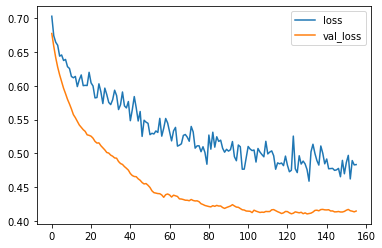

In [19]:
model_loss=pd.DataFrame(ann_mod.history.history)
model_loss.plot()

In [20]:
y_pred_tr = ann_mod.predict_classes(X_train.values)
y_pred_cv = ann_mod.predict_classes(X_cv.values)
precision_tr, recall_tr, fscore_tr, support_tr = precision_recall_fscore_support(
    y_train.values, y_pred_tr, average='macro')
precision_cv, recall_cv, fscore_cv, support_cv = precision_recall_fscore_support(
    y_cv.values, y_pred_cv, average='macro')

/home/chaitanya/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [21]:
print(precision_tr, recall_tr, fscore_tr, support_tr)
print(precision_cv, recall_cv, fscore_cv, support_cv)

0.8447921206310468 0.7938057040998218 0.8074684522276591 None
0.8292200601170701 0.7852247807017544 0.799045850176627 None


In [22]:
ann_mod.save('ann_titanic.h5')


## 3. Model testing

In [23]:
model_list=[logReg_best,knn_best,decTree_best,rnFr_best,svm_best,adab_best,xgbst_best]

In [24]:
for model in model_list:
    print(str(model).split('(')[0])

LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
SVC
AdaBoostClassifier
XGBClassifier


In [25]:
report_d={}
for model in model_list:
    name=str(model).split('(')[0]
    filename = './models/'+name + '_titanic.model'
    pickle.dump(model, open(filename, 'wb'))
    report=testModel(model, X_train, X_cv, y_train, y_cv)
    report_d[name]=report

[07:46:12] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
report_d

{'LogisticRegression': array([0.80318269, 0.76149733, 0.77247191, 0.82922006, 0.78522478,
        0.79904585]),
 'KNeighborsClassifier': array([0.85450323, 0.78912656, 0.80458832, 0.84989824, 0.78275768,
        0.80062724]),
 'DecisionTreeClassifier': array([0.98413537, 0.97642602, 0.98001497, 0.71996753, 0.72286184,
        0.72130701]),
 'RandomForestClassifier': array([0.97501804, 0.96942959, 0.97207655, 0.83694379, 0.81551535,
        0.8240113 ]),
 'SVC': array([0.86268657, 0.78877005, 0.80522007, 0.84989824, 0.78275768,
        0.80062724]),
 'AdaBoostClassifier': array([0.80680084, 0.79572193, 0.80028484, 0.797863  , 0.77891996,
        0.78629944]),
 'XGBClassifier': array([0.95763812, 0.94001783, 0.94749263, 0.84712644, 0.83114035,
        0.83788707])}

In [28]:
report_test={}
for model in model_list:
    name=str(model).split('(')[0]
    filename = './models/'+name + '_titanic.model'
    mod=pickle.load(open(filename, 'rb'))
    report=testModel(mod, X_train, X_test, y_train, y_test)
    report_test[name]=report

[07:47:43] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
report_test

{'LogisticRegression': array([0.80318269, 0.76149733, 0.77247191, 0.7984375 , 0.78268983,
        0.78774704]),
 'KNeighborsClassifier': array([0.85450323, 0.78912656, 0.80458832, 0.81582633, 0.79021879,
        0.79724147]),
 'DecisionTreeClassifier': array([0.98413537, 0.97642602, 0.98001497, 0.80390904, 0.80617761,
        0.8049359 ]),
 'RandomForestClassifier': array([0.97651691, 0.97188057, 0.97409653, 0.83068362, 0.82123552,
        0.82492175]),
 'SVC': array([0.86268657, 0.78877005, 0.80522007, 0.82288037, 0.78622909,
        0.79466937]),
 'AdaBoostClassifier': array([0.80680084, 0.79572193, 0.80028484, 0.82397892, 0.81647362,
        0.81951537]),
 'XGBClassifier': array([0.95763812, 0.94001783, 0.94749263, 0.85124611, 0.84826255,
        0.84963815])}